# 03 BMRA

Run BMRA based on global responses derived from the pathway activity predictions.

In [20]:
import pandas as pd
import numpy as np
import os
import bmra

In [21]:
data_dir_1 = "01_outputs_2020"
data_dir_2 = "02_outputs_2020"
info_dir = "/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg"
out_dir = "03_outputs_2020"


os.makedirs(out_dir, exist_ok = True)

## Load data

### Global responses

Assembled from global responses calculated from predicted pathway activities, and DPD global responses.

In [23]:
def assemble_R_global(pathway_rglobal_file, dpd_rglobal_file):
    """
    Assemble full R_global matrix
    """
    R_global_modules_df = pd.read_csv(pathway_rglobal_file, index_col = 0)

    perts = R_global_modules_df.columns.tolist()

    R_global_DPD_df = pd.read_csv(dpd_rglobal_file, index_col=0).T

    # filter by perts list
    R_global_DPD_df = R_global_DPD_df[R_global_DPD_df.index.isin(perts)]

    # sort by perts list
    R_global_DPD_df["sort_col"] = R_global_DPD_df.index.map({val: i for i, val in enumerate(perts)})
    R_global_DPD_df = R_global_DPD_df.sort_values("sort_col")
    R_global_DPD_df = R_global_DPD_df.drop("sort_col", axis = 1)

    # transpose
    R_global_DPD_df = R_global_DPD_df.T

    R_global_df = pd.concat([R_global_modules_df, R_global_DPD_df])

    return R_global_df

In [24]:
R_global_df = assemble_R_global(
    pathway_rglobal_file = os.path.join(data_dir_2, "R_global_annotated.csv"),
    dpd_rglobal_file = os.path.join(data_dir_1, "R_global_DPDonly_annotated.csv"),
)

modules = R_global_df.index.tolist()
exp_ids = R_global_df.columns.tolist()

R_global = R_global_df.values
n_modules = R_global.shape[0]

print(R_global.shape)
display(R_global_df)

(12, 98)


,ASG002_U251MG_24H:A10,ASG002_U251MG_24H:A11,ASG002_U251MG_24H:A12,ASG002_U251MG_24H:A19,ASG002_U251MG_24H:A20,ASG002_U251MG_24H:A21,ASG002_U251MG_24H:B10,ASG002_U251MG_24H:B11,ASG002_U251MG_24H:B12,ASG002_U251MG_24H:B13,...,ASG002_U251MG_24H:O12,ASG002_U251MG_24H:O13,ASG002_U251MG_24H:O14,ASG002_U251MG_24H:O15,ASG002_U251MG_24H:O22,ASG002_U251MG_24H:O23,ASG002_U251MG_24H:O24,ASG002_U251MG_24H:P16,ASG002_U251MG_24H:P17,ASG002_U251MG_24H:P18
CDK1,0.081089,0.125011,0.173547,-0.607866,0.265283,-0.891511,-0.757245,-0.798125,-0.029274,-0.941224,...,0.286276,0.153923,0.215892,0.297630,0.178274,-0.388498,0.151805,-0.470206,0.187746,-0.481100
CDK2,0.106075,0.116774,0.009522,0.098108,0.053207,0.060171,0.086467,0.065324,0.093244,0.064641,...,0.008067,0.014290,0.020957,0.036406,0.027402,-0.001307,0.047737,0.050421,0.094933,-0.162768
CDK4_6,-0.392868,-0.012786,0.138232,-0.308891,0.001852,-0.599087,-0.385783,-0.248940,-0.058611,-1.644640,...,0.338615,-0.103578,-0.122352,0.450784,-0.048856,0.068505,-0.013369,-1.817373,-1.729637,-1.096661
PI3K,-1.727518,-1.936152,-1.574534,-1.770995,-1.363744,-0.462367,-0.097555,-0.133710,-0.363719,-0.480663,...,-0.550722,-1.123907,0.487393,-1.039486,-1.445170,-1.430944,-0.861013,-1.064608,-1.146680,-0.804919
ERK,-0.056669,-0.902130,-0.573469,-1.376985,-0.240381,-0.070063,-0.050381,0.030621,0.073343,0.244829,...,-0.526101,-1.984386,-1.648063,-1.602062,-1.648365,-1.860993,-2.000578,-0.567394,-1.981519,-0.280683
PDGFR,-1.675321,-0.122161,-0.609842,-0.101268,-0.548778,-0.670138,0.034691,0.067000,0.120590,0.164171,...,-1.116301,-1.519194,-0.416419,-1.324917,-0.532642,-0.051473,-0.709364,-1.862738,-1.005205,-0.338867
Aurora,0.389183,-0.869003,0.133138,0.536756,0.582836,-2.000814,-1.327355,-1.641404,-1.581067,-1.072098,...,0.155092,-0.999820,-0.461707,0.320468,-0.201117,0.633963,0.636174,-0.907239,-1.061106,-0.521568
Estrogen,0.178734,-0.059205,-0.459808,0.059799,-1.570045,-0.187582,-0.071305,0.115753,0.110214,0.153080,...,-1.393176,-0.309838,-0.315023,-0.316760,-0.626627,-0.100765,-1.549463,-0.857565,-0.178473,0.786974
EGFR,-0.246361,-1.112098,0.877428,-1.993334,-0.578342,-1.030612,-0.845636,-1.106294,-1.329879,-1.927600,...,1.008659,-1.167423,0.955037,-0.911178,-1.181477,0.985696,-0.739315,-0.681555,-0.716416,-0.303777
p53,-0.248589,0.238370,0.088570,0.116936,-0.312133,-1.426714,-1.595636,-1.572175,-1.512323,-0.779571,...,0.423060,0.179602,-0.000437,0.424994,0.064967,0.406100,0.383319,0.149433,0.034424,-0.005261


In [25]:
print(R_global_df.values.min())
print(R_global_df.values.max())

-19.044110414335425
21.871067677004643


### Perturbation matrix

In [26]:
inhib_conc_df = pd.read_csv(os.path.join(data_dir_1, "inhib_conc_annotated.csv"), index_col = 0)
#LFC_PLCg = pd.read_csv(os.path.join(info_dir,"PLCg_Data_log_2020.csv"),index_col=0)
#inhib_conc = inhib_conc_df.drop(columns=LFC_PLCg.index).values
inhib_conc = inhib_conc_df.values

n_DPDs = R_global.shape[0] - inhib_conc.shape[0]

pert_modules = np.where(inhib_conc != 0, 1, 0)
pert_DPD = np.zeros((n_DPDs, len(exp_ids)))

pert = np.vstack([pert_modules, pert_DPD])

print(pert.shape)
print(pert)

(12, 98)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Networks

In [28]:
# empty prior
#G_prior = np.zeros((n_modules, n_modules))
G_prior_df = pd.read_excel('/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg/00_outputs_2020_U251MG/ALL_DATA_2020_Jing_u251mg.xlsx', sheet_name = "prior_network", index_col = 0)

G_prior = G_prior_df.values
G_prior_df

,CDK1,CDK2,CDK4_6,p53,EGFR,Aurora,Estrogen,PDGFR,ERK,PI3K,DPD_GBM_onc,DPD_GBM_survival
CDK1,0,0,0,0,0,0,0,0,0,0,0,0
CDK2,0,0,0,0,0,0,0,0,0,0,0,0
CDK4_6,0,0,0,0,0,0,0,0,0,0,0,0
p53,0,0,0,0,0,0,0,0,0,0,0,0
EGFR,0,0,0,0,0,0,0,0,0,0,0,0
Aurora,0,0,0,0,0,0,0,0,0,0,0,0
Estrogen,0,0,0,0,0,0,0,0,0,0,0,0
PDGFR,0,0,0,0,0,0,0,0,0,0,0,0
ERK,0,0,0,0,0,0,0,0,0,0,0,0
PI3K,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#G_prior_r_df = pd.read_excel(os.path.join(info_dir, "ALL_DATA_2020.xlsx"), sheet_name = "prior_r", index_col = 0)

#G_prior_r = G_prior_r_df.values
#G_prior_r_df

In [29]:
G_not = np.eye(n_modules)
G_not[:, n_modules - n_DPDs :] = 1

G_not

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

## Run BMRA

In [30]:
n_gibbs = 200_000
n_window = 5_000

mode = "all"
n_iterations = 1

In [31]:
G_prior

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
A_mean, A_sd, r_mean, r_sd = bmra.run_bmra(R_global,
            pert,
            G_prior,
            G_not,
            #r_prior = G_prior_r,
            n_gibbs = n_gibbs,
            n_window = n_window,
            mode = mode,
            n_iterations = n_iterations,
        )

A_mean_df = pd.DataFrame(A_mean, index = modules, columns = modules)
A_sd_df = pd.DataFrame(A_sd, index = modules, columns = modules)
r_mean_df = pd.DataFrame(r_mean, index = modules, columns = modules)
r_sd_df = pd.DataFrame(r_sd, index = modules, columns = modules)

display(A_mean_df)
display(A_sd_df)
display(r_mean_df)
display(r_sd_df)

A_mean_df.to_csv(os.path.join(out_dir, "A_mean.csv"))
A_sd_df.to_csv(os.path.join(out_dir, "A_sd.csv"))
r_mean_df.to_csv(os.path.join(out_dir, "r_mean.csv"))
r_sd_df.to_csv(os.path.join(out_dir, "r_sd.csv"))

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000168,0.023215,0.0,0.0
CDK2,0.000594,0.0,0.000937,0.001804,0.281568,0.162461,0.002960,0.002105,0.856154,0.003216,0.0,0.0
CDK4_6,1.000000,0.0,0.000000,0.000511,0.000000,0.000000,0.000000,0.007389,1.000000,0.000000,0.0,0.0
PI3K,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000881,0.000000,0.000000,0.154647,0.0,0.0
ERK,0.030613,1.0,0.000817,1.000000,0.000000,0.055584,0.891183,0.205407,0.921337,0.000966,0.0,0.0
PDGFR,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
Aurora,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0
Estrogen,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0
p53,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000e+00,0.000000e+00,2.553513e-15,0.000000e+00,2.553513e-15,0.000000e+00,2.553513e-15,0.000000e+00,1.296074e-02,1.505845e-01,0.0,0.0
CDK2,2.435802e-02,0.000000e+00,3.059578e-02,4.243028e-02,4.497640e-01,3.688734e-01,5.432639e-02,4.583228e-02,3.509330e-01,5.661708e-02,0.0,0.0
CDK4_6,1.110223e-15,0.000000e+00,0.000000e+00,2.259354e-02,0.000000e+00,0.000000e+00,0.000000e+00,8.564345e-02,1.110223e-15,0.000000e+00,0.0,0.0
PI3K,0.000000e+00,0.000000e+00,1.776357e-15,0.000000e+00,1.776357e-15,1.776357e-15,2.966378e-02,0.000000e+00,0.000000e+00,3.615675e-01,0.0,0.0
ERK,1.722680e-01,6.661338e-16,2.856768e-02,6.661338e-16,0.000000e+00,2.291169e-01,3.114093e-01,4.039987e-01,2.692113e-01,3.105848e-02,0.0,0.0
PDGFR,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-15,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-15,2.220446e-15,0.000000e+00,0.0,0.0
Aurora,8.881784e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,8.881784e-16,0.0,0.0
Estrogen,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.992007e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
EGFR,0.000000e+00,4.218847e-15,0.000000e+00,0.000000e+00,4.218847e-15,0.000000e+00,4.218847e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
p53,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.000000,0.476475,0.000000,-0.096299,0.000000,0.208941,0.000000,0.000010,0.002827,0.0,0.0
CDK2,0.000004,0.000000,-0.000011,-0.000006,0.015881,-0.012720,-0.000008,-0.000073,-0.034017,-0.000075,0.0,0.0
CDK4_6,0.471482,0.000000,0.000000,0.000023,0.000000,0.000000,0.000000,-0.000623,0.066610,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.234674,0.000000,0.292540,0.193399,0.000061,0.000000,0.000000,-0.022456,0.0,0.0
ERK,-0.006230,1.098534,0.000046,0.470002,0.000000,0.008606,-0.152699,0.042402,0.207663,0.000045,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.313951,0.000000,0.000000,0.000000,0.488042,0.122887,0.000000,0.0,0.0
Aurora,0.565208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252043,0.449139,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279592,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.968295,0.000000,0.000000,0.432281,0.000000,0.398443,0.000000,0.000000,0.000000,0.0,0.0
p53,0.268269,0.000000,0.000000,0.000000,0.000000,0.000000,0.237948,0.000000,0.000000,0.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.000000,0.034787,0.000000,0.017125,0.000000,0.018111,0.000000,0.000801,0.018670,0.0,0.0
CDK2,0.000768,0.000000,0.000648,0.000887,0.027171,0.030323,0.000577,0.002146,0.017808,0.001698,0.0,0.0
CDK4_6,0.021277,0.000000,0.000000,0.001042,0.000000,0.000000,0.000000,0.007344,0.013140,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.048336,0.000000,0.029060,0.035928,0.002090,0.000000,0.000000,0.054527,0.0,0.0
ERK,0.036533,0.220336,0.002087,0.059871,0.000000,0.037752,0.067475,0.088474,0.079612,0.002063,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.026150,0.000000,0.000000,0.000000,0.039482,0.019596,0.000000,0.0,0.0
Aurora,0.031146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018659,0.030633,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.001261,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,0.100138,0.000000,0.000000,0.023762,0.000000,0.020943,0.000000,0.000000,0.000000,0.0,0.0
p53,0.021159,0.000000,0.000000,0.000000,0.000000,0.000000,0.012943,0.000000,0.000000,0.000000,0.0,0.0


In [33]:
np.fill_diagonal(r_mean_df.values,-1)
rm_minus_inv = pd.DataFrame(np.linalg.pinv(r_mean_df),index=r_mean_df.index,columns=r_mean_df.columns)*(-1)
rm_minus_inv.to_csv(os.path.join(out_dir, 'r_minv.csv'))
display(rm_minus_inv)

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.724949,-0.286984,0.808087,-0.058826,-0.117268,-0.011882,0.498112,-0.011254,0.163340,0.229935,-2.630910e-16,-1.182467e-16
CDK2,-0.023144,1.040800,-0.012584,-0.006587,-0.002716,-0.016892,-0.025131,-0.008427,-0.045217,-0.011284,1.780178e-16,-6.392388e-17
CDK4_6,0.853165,-0.177678,1.404890,-0.006916,-0.015074,0.000432,0.277089,-0.001291,0.166394,0.127031,4.275128e-17,-9.966716e-18
PI3K,0.200070,0.326964,0.399075,1.294270,0.428952,0.295123,0.032420,0.161948,0.148978,-0.013942,2.189549e-15,2.512880e-16
ERK,-0.042459,1.228335,0.137157,0.670462,1.317489,0.163223,-0.138316,0.135349,0.226142,-0.077332,-3.891306e-16,7.554300e-18
PDGFR,0.157990,0.028346,0.196182,0.515151,0.241934,1.278661,0.102060,0.634175,0.245200,0.034727,-2.384538e-16,3.234084e-16
Aurora,1.493391,-0.399850,0.721731,0.043295,0.080481,0.017357,1.681105,0.011463,0.504248,0.758334,-1.930549e-15,-7.792041e-17
Estrogen,0.044173,0.007925,0.054851,0.144032,0.067643,0.357503,0.028535,1.177310,0.068556,0.009709,1.354203e-16,8.079939e-17
EGFR,0.599087,-0.636132,0.359045,0.313457,0.604223,0.093831,0.634368,0.071236,1.342455,0.279650,-4.217930e-16,5.019708e-16
p53,0.818100,-0.172132,0.388519,-0.005479,-0.012309,0.000942,0.533644,-0.000292,0.163804,1.242129,-3.054479e-17,8.301174e-17


In [34]:
con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in r_mean_df.index:
    for con_from in r_mean_df.columns:
        if ((r_mean_df.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,r_mean_df.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net.txt'),sep='\t',index=False)
display(con_mat)

,From,To,Strength
0,CDK4_6,CDK1,0.476475
1,ERK,CDK1,-0.096299
2,Aurora,CDK1,0.208941
3,EGFR,CDK1,0.000010
4,p53,CDK1,0.002827
5,CDK1,CDK2,0.000004
6,CDK4_6,CDK2,-0.000011
7,PI3K,CDK2,-0.000006
8,ERK,CDK2,0.015881
9,PDGFR,CDK2,-0.012720


In [35]:
# now the same but with filtered matrices
# threshold value
Athr = 0.5

rm_filt = r_mean_df[np.abs(A_mean_df) > Athr].fillna(0).copy()
np.fill_diagonal(rm_filt.values,-1)
rm_filt.to_csv(os.path.join(out_dir, 'r_mean_filt.csv'))
display(rm_filt)

rm_filt_minus_inv = pd.DataFrame(np.linalg.pinv(rm_filt),index=rm_filt.index,columns=rm_filt.columns)*(-1)
rm_filt_minus_inv.to_csv(os.path.join(out_dir, 'r_minv_filt.csv'))
display(rm_minus_inv)

con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in rm_filt.index:
    for con_from in rm_filt.columns:
        if ((rm_filt.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,rm_filt.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net_filt.txt'),sep='\t',index=False)
#display(con_mat)


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.476475,0.000000,-0.096299,0.000000,0.208941,0.000000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034017,0.000000,0.0,0.0
CDK4_6,0.471482,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066610,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.234674,-1.000000,0.292540,0.193399,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.098534,0.000000,0.470002,-1.000000,0.000000,-0.152699,0.000000,0.207663,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.313951,0.000000,-1.000000,0.000000,0.488042,0.122887,0.000000,0.0,0.0
Aurora,0.565208,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.252043,0.449139,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279592,0.000000,-1.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.968295,0.000000,0.000000,0.432281,0.000000,0.398443,0.000000,-1.000000,0.000000,0.0,0.0
p53,0.268269,0.000000,0.000000,0.000000,0.000000,0.000000,0.237948,0.000000,0.000000,-1.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.724949,-0.286984,0.808087,-0.058826,-0.117268,-0.011882,0.498112,-0.011254,0.163340,0.229935,-2.630910e-16,-1.182467e-16
CDK2,-0.023144,1.040800,-0.012584,-0.006587,-0.002716,-0.016892,-0.025131,-0.008427,-0.045217,-0.011284,1.780178e-16,-6.392388e-17
CDK4_6,0.853165,-0.177678,1.404890,-0.006916,-0.015074,0.000432,0.277089,-0.001291,0.166394,0.127031,4.275128e-17,-9.966716e-18
PI3K,0.200070,0.326964,0.399075,1.294270,0.428952,0.295123,0.032420,0.161948,0.148978,-0.013942,2.189549e-15,2.512880e-16
ERK,-0.042459,1.228335,0.137157,0.670462,1.317489,0.163223,-0.138316,0.135349,0.226142,-0.077332,-3.891306e-16,7.554300e-18
PDGFR,0.157990,0.028346,0.196182,0.515151,0.241934,1.278661,0.102060,0.634175,0.245200,0.034727,-2.384538e-16,3.234084e-16
Aurora,1.493391,-0.399850,0.721731,0.043295,0.080481,0.017357,1.681105,0.011463,0.504248,0.758334,-1.930549e-15,-7.792041e-17
Estrogen,0.044173,0.007925,0.054851,0.144032,0.067643,0.357503,0.028535,1.177310,0.068556,0.009709,1.354203e-16,8.079939e-17
EGFR,0.599087,-0.636132,0.359045,0.313457,0.604223,0.093831,0.634368,0.071236,1.342455,0.279650,-4.217930e-16,5.019708e-16
p53,0.818100,-0.172132,0.388519,-0.005479,-0.012309,0.000942,0.533644,-0.000292,0.163804,1.242129,-3.054479e-17,8.301174e-17


In [36]:
# number of zero elements in the matrix
display(len(rm_filt.index)*len(rm_filt.columns) - rm_filt.astype(bool).sum().sum())

101

In [37]:
# number of non-zero elements in the matrix
display(rm_filt.astype(bool).sum().sum() - len(modules))

31

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
rm_minus_inv=pd.read_csv(os.path.join(out_dir, 'r_minv.csv'),index_col=0)
display(rm_minus_inv)

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.724949,-0.286984,0.808087,-0.058826,-0.117268,-0.011882,0.498112,-0.011254,0.163340,0.229935,-2.630910e-16,-1.182467e-16
CDK2,-0.023144,1.040800,-0.012584,-0.006587,-0.002716,-0.016892,-0.025131,-0.008427,-0.045217,-0.011284,1.780178e-16,-6.392388e-17
CDK4_6,0.853165,-0.177678,1.404890,-0.006916,-0.015074,0.000432,0.277089,-0.001291,0.166394,0.127031,4.275128e-17,-9.966716e-18
PI3K,0.200070,0.326964,0.399075,1.294270,0.428952,0.295123,0.032420,0.161948,0.148978,-0.013942,2.189549e-15,2.512880e-16
ERK,-0.042459,1.228335,0.137157,0.670462,1.317489,0.163223,-0.138316,0.135349,0.226142,-0.077332,-3.891306e-16,7.554300e-18
PDGFR,0.157990,0.028346,0.196182,0.515151,0.241934,1.278661,0.102060,0.634175,0.245200,0.034727,-2.384538e-16,3.234084e-16
Aurora,1.493391,-0.399850,0.721731,0.043295,0.080481,0.017357,1.681105,0.011463,0.504248,0.758334,-1.930549e-15,-7.792041e-17
Estrogen,0.044173,0.007925,0.054851,0.144032,0.067643,0.357503,0.028535,1.177310,0.068556,0.009709,1.354203e-16,8.079939e-17
EGFR,0.599087,-0.636132,0.359045,0.313457,0.604223,0.093831,0.634368,0.071236,1.342455,0.279650,-4.217930e-16,5.019708e-16
p53,0.818100,-0.172132,0.388519,-0.005479,-0.012309,0.000942,0.533644,-0.000292,0.163804,1.242129,-3.054479e-17,8.301174e-17


In [40]:
rm_minus_inv.columns

Index(['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora', 'Estrogen',
       'EGFR', 'p53', 'GBM_onc', 'GBM_survival'],
      dtype='object')

In [41]:
df_subset=rm_minus_inv[['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora',
       'Estrogen', 'EGFR', 'p53']]
df_subset = df_subset.loc[['GBM_onc', 'GBM_survival']]

In [42]:
t_df_subset=df_subset.T

In [43]:
df_subset.reset_index(inplace=True)

In [44]:
df_subset

,index,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53
0,GBM_onc,-1.102798,0.164680,-1.799239,-0.209425,-0.050966,-0.574622,-0.084251,-0.281492,-0.227893,-0.772316
1,GBM_survival,3.174453,-2.213933,0.450287,-4.526381,-1.327819,-1.012614,4.264539,-0.550620,0.780008,2.026096


Text(0.5, 1.0, 'Predicted global signaling pathway responses of U251MG cell line under conditions ')

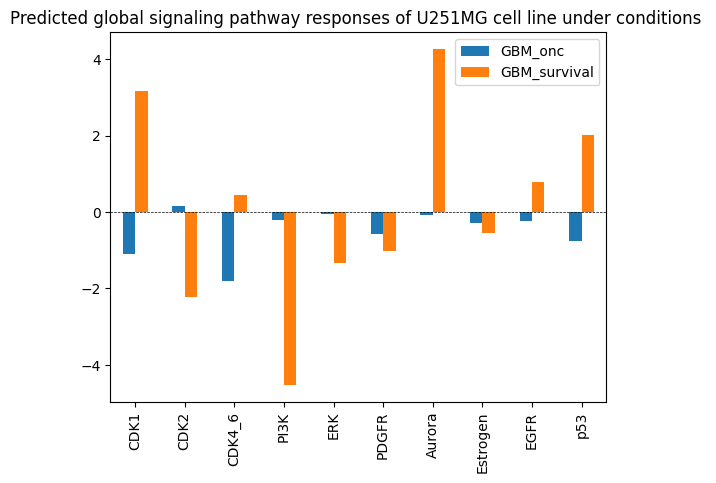

In [45]:
t_df_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted global signaling pathway responses of U251MG cell line under conditions ")

In [46]:
rm_filt

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.476475,0.000000,-0.096299,0.000000,0.208941,0.000000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034017,0.000000,0.0,0.0
CDK4_6,0.471482,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066610,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.234674,-1.000000,0.292540,0.193399,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.098534,0.000000,0.470002,-1.000000,0.000000,-0.152699,0.000000,0.207663,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.313951,0.000000,-1.000000,0.000000,0.488042,0.122887,0.000000,0.0,0.0
Aurora,0.565208,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.252043,0.449139,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279592,0.000000,-1.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.968295,0.000000,0.000000,0.432281,0.000000,0.398443,0.000000,-1.000000,0.000000,0.0,0.0
p53,0.268269,0.000000,0.000000,0.000000,0.000000,0.000000,0.237948,0.000000,0.000000,-1.000000,0.0,0.0


In [47]:
display(rm_filt)
rm_subset=rm_filt[['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora','Estrogen', 'EGFR', 'p53']]

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.476475,0.000000,-0.096299,0.000000,0.208941,0.000000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034017,0.000000,0.0,0.0
CDK4_6,0.471482,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066610,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.234674,-1.000000,0.292540,0.193399,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.098534,0.000000,0.470002,-1.000000,0.000000,-0.152699,0.000000,0.207663,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.313951,0.000000,-1.000000,0.000000,0.488042,0.122887,0.000000,0.0,0.0
Aurora,0.565208,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.252043,0.449139,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279592,0.000000,-1.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.968295,0.000000,0.000000,0.432281,0.000000,0.398443,0.000000,-1.000000,0.000000,0.0,0.0
p53,0.268269,0.000000,0.000000,0.000000,0.000000,0.000000,0.237948,0.000000,0.000000,-1.000000,0.0,0.0


In [48]:
rm_subset

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53
CDK1,-1.000000,0.000000,0.476475,0.000000,-0.096299,0.000000,0.208941,0.000000,0.000000,0.000000
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034017,0.000000
CDK4_6,0.471482,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066610,0.000000
PI3K,0.000000,0.000000,0.234674,-1.000000,0.292540,0.193399,0.000000,0.000000,0.000000,0.000000
ERK,0.000000,1.098534,0.000000,0.470002,-1.000000,0.000000,-0.152699,0.000000,0.207663,0.000000
PDGFR,0.000000,0.000000,0.000000,0.313951,0.000000,-1.000000,0.000000,0.488042,0.122887,0.000000
Aurora,0.565208,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.252043,0.449139
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279592,0.000000,-1.000000,0.000000,0.000000
EGFR,0.000000,-0.968295,0.000000,0.000000,0.432281,0.000000,0.398443,0.000000,-1.000000,0.000000
p53,0.268269,0.000000,0.000000,0.000000,0.000000,0.000000,0.237948,0.000000,0.000000,-1.000000


In [49]:
rm_subset=rm_subset.loc[['GBM_onc','GBM_survival']]
rm_subset=rm_subset.T
display(rm_subset)

,GBM_onc,GBM_survival
CDK1,0.000000,0.000000
CDK2,0.000000,0.000000
CDK4_6,-1.224633,0.000000
PI3K,0.000000,-3.584417
ERK,0.000000,0.000000
PDGFR,-0.452884,0.000000
Aurora,0.412974,2.605873
Estrogen,0.000000,0.000000
EGFR,0.000000,0.000000
p53,-0.736046,0.000000


Text(0.5, 1.0, 'Predicted local signaling pathway responses of U251MG cell line under conditions ')

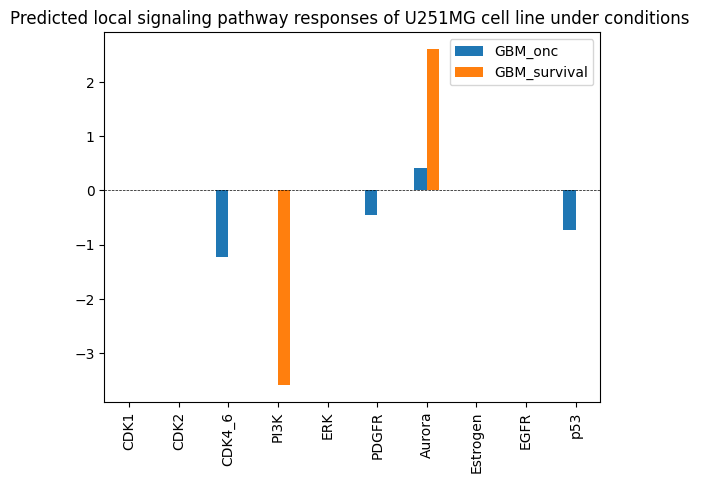

In [50]:
rm_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted local signaling pathway responses of U251MG cell line under conditions ")